## Convert all .tif files in a folder to image files (png/jpg)

In [1]:
import glob

from pprint import pprint
from tqdm.notebook import tqdm

import rasterio
import matplotlib.pyplot as plt

import numpy as np

from skimage import exposure
from skimage.io import imsave, imread

In [80]:
# define parameters
output_path = '../../data/nodata_check/output/'

# define paths with raster data
rasters_file_path = '../../data/nodata_check/*.tif'

# image specifics:
band_list = [3,2,1]
file_type = 'jpg' # jpg or png
upper_percentile = 98
lower_percentile = 2
max_single_value_count = 600


# misc
plot_results = True

In [45]:
# find files in raster folder
raster_files = glob.glob(rasters_file_path)

In [46]:
# check if the right files are selected
print(len(raster_files))
pprint(raster_files[0:2])

3
['../../data/nodata_check/example_100.tif',
 '../../data/nodata_check/example_116.tif']


/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


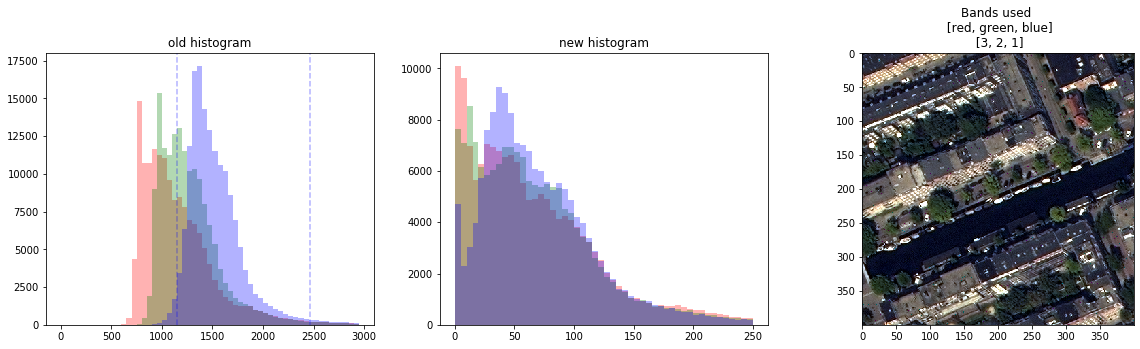

stretch min, max values:  1154.0 2465.0
--------------------------------------------
original file: 
 ../../data/nodata_check/example_100.tif
--------------------------------------------
file written to: 
 ../../data/nodata_check/output/example_example_100.jpg
--------------------------------------------


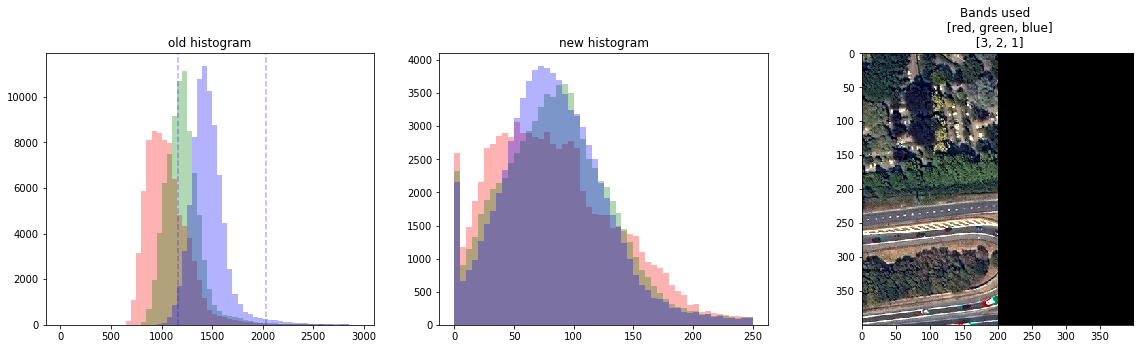

stretch min, max values:  1161.0 2027.0
--------------------------------------------
original file: 
 ../../data/nodata_check/example_116.tif
--------------------------------------------
file written to: 
 ../../data/nodata_check/output/example_example_116.jpg
--------------------------------------------


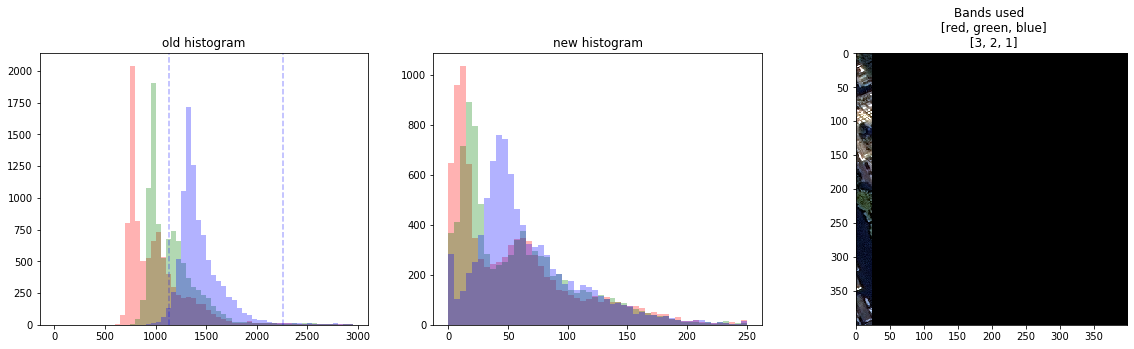

stretch min, max values:  1135.98 2260.0200000000004
--------------------------------------------
original file: 
 ../../data/nodata_check/example_297.tif
--------------------------------------------
file written to: 
 ../../data/nodata_check/output/example_example_297.jpg
--------------------------------------------



In [99]:
# loop over all files and write them to output folder
for raster_file in tqdm(raster_files):

    dataset = rasterio.open(raster_file)
    
    # read and reformat raster data
    img = dataset.read()
    img_plot_raw = img[band_list,:,:]
    img_plot = np.rot90(np.fliplr(img_plot_raw.T))
    
    # correct exposure for each band individually
    img_plot_enhance = np.array(img_plot, copy=True)
    
  
    for band in range(3):
        
        # check max amount of a single value
        values, counts = np.unique(img_plot, return_counts=True)
        index_nodata = np.argmax(counts)
        nodata_value = values[index_nodata]
        max_count_single_value = np.max(values)
        
        # if there are more than specific values set them as nan
        if max_count_single_value > max_single_value_count:
            img_plot[img_plot == nodata_value] = np.nan 
            
        p_1, p_2 = np.nanpercentile(img_plot[:,:,band], (lower_percentile, upper_percentile))
        img_plot_enhance[:,:,band] = exposure.rescale_intensity(img_plot[:,:,band], 
                                                            in_range=(p_1, p_2), 
                                                            out_range = (0,255))  

    # name string 
    orig_file_name = raster_file.split('/')[-1].split('.')[0]
    
    # write jpg file
    file_path_jpg = '{0}example_{1}.{2}'.format(output_path,orig_file_name, file_type)
    file_name_jpg = 'example_{0}.{1}'.format(orig_file_name, file_type)
    imsave(file_path_jpg, img_plot_enhance.astype('uint8'))
    
    
    
    ### plotting results if needed
    if plot_results:

        plt.figure(figsize = (20,5))
        
        for band in range(3):
            plt.subplot(131)
            plt.hist(img_plot[:,:,band].flatten(), bins = range(0,3000,50), 
                     alpha = 0.3 ,color = colors[band])
            if band == 2:
                plt.axvline(x = p_1, c = 'blue', alpha = 0.3, linestyle = '--')
                plt.axvline(x = p_2, c = 'blue', alpha = 0.3, linestyle = '--')
            plt.title('old histogram')            
            plt.subplot(132)
            plt.hist(img_plot_enhance[:,:,band].flatten(), bins = range(0,255,5), 
                     alpha = 0.3, color = colors[band])
            plt.title('new histogram')
            
        plt.subplot(133)
        plt.imshow(img_plot_enhance.astype(int), label = 'img')
        plt.title('Bands used \n [red, green, blue]\n {}'.format(band_list))
        plt.show()

        print('stretch min, max values: ' , p_1, p_2)
        
        print('--------------------------------------------')
        print('original file: \n', raster_file)
        print('--------------------------------------------')
        print('file written to: \n', file_path_jpg)
        print('--------------------------------------------')